
SumSquares: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 872 kB 50.6 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=9ece6a283ac79bcafea5963d71f1f4f67609a6cdb3fba0db270f2502b6ae0b7e
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=6c613709bb5ef3e91c7c31046e5abf356839edb9c4ae799c7394cfda9f54f383
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm, t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SumSquares'
n_test = 500
eps = 1e-08

util_gp = 'EI_gp'
util_stp = 'EI_stp'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - Sum Squares(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )
        
# Constraints:
lb = -5.12
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds   

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI_stp': self.EI_stp,
            'EI_gp': self.EI_gp,
        }

        self.f = mode_dict[mode]
    
    def EI_stp(self, tau, mean, std, ds, dm, nu=3.0):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * t.cdf(gamma, df=nu) + (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * (t.cdf(gamma, df=nu) * dmdx + gamma * t.pdf(gamma, df=nu) \
            * (1 - (nu + gamma ** 2)/(nu - 1) + 2/(nu - 1) * dmdx))
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def EI_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact EI: StdDev. x \t Approx EI: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_gp = time.time()
start_gp


1663059249.7797284

In [13]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), objfunc, param)
gp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 4.04077223 -4.24914728]	 52.43834538835027	 1.4334486961549602	 3.4489756845924497	 4.163974683192937
2  	 [3.95540519 5.12      ]	 68.07403023591242	 1.4334486961549602	 3.3878383996330093	 3.5005012055534523
3  	 [5.12       0.42690956]	 26.57890353728757	 1.4334486961549602	 3.15227018152962	 3.564639216485689
4  	 [-5.12        4.36680096]	 64.35230119366302	 1.4334486961549602	 3.370663359363788	 4.0553052367487945
5  	 [ 0.77902525 -1.82331002]	 7.2557991758824

In [14]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), objfunc, param)
gp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [4.65822565 5.12      ]	 74.12786624034281	 1.1358959044973735	 3.793495730061243	 3.7991229147714978
2  	 [ 4.84262551 -3.96515151]	 54.89587485526295	 1.1358959044973735	 2.7483713464466506	 3.7930249222606087
3  	 [-0.49783222  5.12      ]	 52.67663691998099	 1.1358959044973735	 3.698685800326653	 4.058112345323993
4  	 [4.16937798 0.52775354]	 17.940760340983772	 1.1358959044973735	 3.3633254722324413	 3.4196991947885618
5  	 [-5.12 -5.12]	 78.64319999999998	 1.1358

In [15]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), objfunc, param)
gp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 1.78282979 -3.07043083]	 22.033572998458702	 4.609047504113831	 2.080558878714637	 3.531962042320513
2  	 [-3.52881074  4.85538913]	 59.60211244097039	 4.609047504113831	 2.742731871411798	 3.937381998432584
3  	 [ 5.12      -0.3773989]	 26.499259852483945	 4.609047504113831	 2.6902293515476057	 3.1984000212581876
4  	 [-0.99705128 -5.12      ]	 53.42291126073889	 4.609047504113831	 3.0980546557030793	 2.8601588315267703
5  	 [0.90918729 4.87135527]	 48.28682587351447	 4.60904750

In [16]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

gp_4= dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), objfunc, param)
gp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-1.14362514  4.64615262]	 44.481346743661575	 7.289910254474112	 2.9160309599087104	 3.8217678725355855
2  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 3.6941402497674853	 3.610537251250352
3  	 [-0.9772831 -5.12     ]	 53.38388225290658	 7.289910254474112	 3.5172193743490783	 3.711135803421386
4	 [0.61262941 1.13479131]	 2.950817435087264	 2.950817435087264	 3.213597652615168	 3.4189480861208605
5  	 [-5.12        2.58975774]	 39.62809034363863	 2.950817435087264	 2.885

In [17]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), objfunc, param)
gp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 4.32895605 -5.09732646]	 70.70533460957368	 2.6327313115208373	 4.41822901128693	 4.499439960007176
2  	 [5.12 5.12]	 78.64320000000001	 2.6327313115208373	 4.325609223196669	 3.928369913497632
3  	 [-5.12       -0.29642107]	 26.390130906870272	 2.6327313115208373	 3.3559403839575737	 3.6433785072186846
4  	 [1.00930079 5.12      ]	 53.4474880829955	 2.6327313115208373	 3.369004338030763	 3.325394358259418
5  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 3.2433

In [18]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), objfunc, param)
gp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [2.19009888 5.12      ]	 57.22533310680345	 1.4757178799086357	 3.8938233923482723	 3.857012510005505
2  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 3.8359252616388826	 3.8529075592463884
3  	 [-3.01245635  5.12      ]	 61.5036932630161	 1.4757178799086357	 3.5810487068786037	 3.5820889271597576
4  	 [5.12       2.13583625]	 35.33799293336946	 1.4757178799086357	 3.262782922873095	 3.2687448732841995
5  	 [-0.90911896 -4.20509113]	 36.19208013970827	 1.47571

In [19]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), objfunc, param)
gp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 3.301788783268242	 3.377456193469764
2  	 [3.47906186 5.12      ]	 64.53267142431227	 5.622520458601941	 3.687463003663664	 3.7176658546865755
3  	 [ 4.60106308 -4.08987229]	 54.62389212361763	 5.622520458601941	 3.3012614952810666	 3.3304438224345527
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 2.889414688252331	 3.046307140328312
5	 [ 1.26778926 -0.69601606]	 2.5761663018498875	 2.576166301

In [20]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), objfunc, param)
gp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [0.03252479 1.99788883]	 7.984177400212775	 0.1518306274298758	 3.0082400260186315	 3.749786221681577
2  	 [-5.03492225  2.95509263]	 42.81558690689544	 0.1518306274298758	 3.0734788919679232	 3.4551867222608723
3  	 [-1.7372006  5.12     ]	 55.44666591362916	 0.1518306274298758	 2.80062561605492	 3.2063813725670296
4  	 [ 2.61852195 -4.65214283]	 50.14152293437924	 0.1518306274298758	 3.066081627137047	 3.830791582752968
5  	 [-5.12       -1.44108206]	 30.3678349887081	 0.

In [21]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [5.12 5.12]	 78.64320000000001	 14.00341364504739	 2.97471277204924	 2.9015048208642384
2  	 [-0.71921853  4.11475232]	 34.37964852502853	 14.00341364504739	 3.2873440621875427	 3.6925402559920446
3  	 [ 5.12       -1.23922894]	 29.28577674150329	 14.00341364504739	 3.2332348955757384	 4.0445464755427265
4	 [1.22324519 0.71921471]	 2.530868410983344	 2.530868410983344	 3.2510640150500616	 3.665010110653459
5  	 [3.49274801 1.82644176]	 18.87106772816955	 2.530868410983344	 3.34

In [22]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), objfunc, param)
gp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12       -0.36575711]	 26.48195652786448	 14.855028828430257	 3.5904008134800907	 3.7809645500304745
2  	 [5.12 5.12]	 78.64320000000001	 14.855028828430257	 3.281124488444716	 3.444164457373556
3  	 [-4.19726726 -0.70771609]	 18.618776591669107	 14.855028828430257	 2.7119989973772727	 3.3160893184259193
4  	 [0.20972177 5.12      ]	 52.47278322104103	 14.855028828430257	 3.4685923886852894	 3.622389677147536
5	 [ 2.00133395 -0.65417626]	 4.861230722576716	 4.86123072

In [23]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), objfunc, param)
gp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 3.03550212 -4.46785095]	 49.13765732819627	 0.7122141741228657	 2.686370835414964	 3.9529838321385635
2  	 [ 4.96308933 -0.59491482]	 25.34010298072491	 0.7122141741228657	 2.5495153641901935	 3.1204325681850396
3  	 [-1.19896852  5.12      ]	 53.86632550764567	 0.7122141741228657	 3.203201429859622	 3.7659259924361743
4  	 [ 1.28140813 -1.21714588]	 4.604894973126546	 0.7122141741228657	 2.463900599458722	 2.6024585826788433
5  	 [-1.69216183 -1.61119498]	 8.05531017348

In [24]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), objfunc, param)
gp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12 5.12]	 78.64320000000001	 6.112828495563743	 3.7035472890922616	 3.664352039607077
2  	 [-5.12 -5.12]	 78.64320000000001	 6.112828495563743	 3.603562655993318	 3.1430042803363434
3  	 [2.21060156 0.79247397]	 6.142789264583078	 6.112828495563743	 2.998313901225209	 2.821666498570226
4  	 [0.42823336 4.67757823]	 43.94285991467947	 6.112828495563743	 2.986077824527493	 3.077144611028562
5  	 [-0.4673844  -4.08946082]	 33.66582782388065	 6.112828495563743	 2.622597152841547	 

In [25]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), objfunc, param)
gp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-4.98875265 -5.12      ]	 77.31645300895626	 12.440151302029248	 2.797645369960195	 3.166668561947521
2  	 [-4.39199693  2.0756854 ]	 27.906576763179505	 12.440151302029248	 2.676785498513581	 3.621381099734055
3	 [-2.15996326 -1.35939384]	 8.36134453142119	 8.36134453142119	 3.090541073257211	 3.4998618978017264
4  	 [-1.90088387  5.12      ]	 56.04215949678534	 8.36134453142119	 3.1455723818445627	 3.6122813687649233
5  	 [-0.47880672 -5.12      ]	 52.65805587212888	 8.36134453

In [26]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), objfunc, param)
gp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 6.942951853664133	 4.121274436170594	 3.9768855759570823
2  	 [5.12 5.12]	 78.64320000000001	 6.942951853664133	 3.9666011310036655	 3.9488983817451895
3  	 [-5.12        0.36978819]	 26.487886607475154	 6.942951853664133	 2.8111046167207094	 3.7193130546290223
4  	 [4.78909935 0.0121152 ]	 22.9357661657475	 6.942951853664133	 3.039484181486929	 3.1541528424549536
5	 [-1.7489573   0.06030275]	 3.066124484489773	 3.066124484489773	 2.984701878973

In [27]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), objfunc, param)
gp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [4.12498913 5.12      ]	 69.44433534653355	 5.478261179905657	 3.729730094167296	 3.766997094729225
2  	 [-1.61427045  5.12      ]	 55.03466908322628	 5.478261179905657	 2.8254618495368256	 3.6153089732436547
3	 [1.80215427 1.00841853]	 5.281575878408494	 5.281575878408494	 2.9680328069369257	 3.212933681137238
4  	 [-5.12       2.7993309]	 41.88690693468751	 5.281575878408494	 2.9194718568305884	 3.547384679383585
5  	 [5.12       0.84586656]	 27.645380472801122	 5.2815758784

In [28]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), objfunc, param)
gp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [5.12 5.12]	 78.64320000000001	 8.141239237549925	 3.916851608419127	 3.8994468146665966
2  	 [5.12       0.06492156]	 26.22282961736193	 8.141239237549925	 3.4043356895336654	 3.2869652556692786
3  	 [0.38934266 3.73115153]	 27.99457111540883	 8.141239237549925	 3.5157944415217006	 3.890540294218093
4  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 3.3818447953682025	 3.5898895109093982
5	 [0.61640032 0.23811921]	 0.4933508728333715	 0.4933508728333715	 2.63638978601

In [29]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), objfunc, param)
gp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856025273	 3.1817562258207746	 3.330997861947753	 4.404836650990023
2  	 [-1.25765516  5.12      ]	 54.01049649555178	 3.1817562258207746	 3.1512014650356934	 3.3674817751446904
3  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 3.407266155412709	 3.386126911556011
4  	 [ 0.93267141 -3.01501446]	 19.05050033633732	 3.1817562258207746	 3.2802510471851196	 3.669815815496104
5  	 [ 5.12       -0.66225644]	 27.091567173816713	 3.18175622

In [30]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), objfunc, param)
gp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 3.077046067626628	 3.6505861325773443
2  	 [-2.12750099 -0.37273337]	 4.80412080606555	 2.3773200933391867	 2.611673796822958	 2.5847399606849
3  	 [-1.38388786  2.93401946]	 19.132085955660546	 2.3773200933391867	 2.9546443621558236	 3.0752340434726504
4  	 [-5.12       -1.70034653]	 31.99675663722693	 2.3773200933391867	 3.10647722839905	 3.5576315421726643
5  	 [ 0.2392604  -2.31514409]	 10.777029851248393	 2.

In [31]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), objfunc, param)
gp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 4.82667719 -3.73099312]	 51.13743209688758	 22.814458446152262	 3.4513529092014785	 4.589131028028589
2	 [-0.88068028  0.08134902]	 0.7888330757079672	 0.7888330757079672	 4.076574730412819	 3.837125947206755
3  	 [5.12 5.12]	 78.64320000000001	 0.7888330757079672	 3.4390683119261056	 3.191820875666437
4  	 [-5.12       -1.18501843]	 29.022937359837208	 0.7888330757079672	 3.024198829032659	 3.228615543326342
5  	 [ 1.45315185 -0.97755119]	 4.022862961377536	 0.788833075707

In [32]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), objfunc, param)
gp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-3.73124233 -5.12      ]	 66.35096932954521	 1.615187047660523	 2.9592848905706246	 2.8636010936681755
2  	 [ 5.12       -1.00299666]	 28.22640459558733	 1.615187047660523	 2.7529317336889503	 3.5789598992602683
3  	 [1.4218861  0.40795045]	 2.3546072162223264	 1.615187047660523	 2.652461525515539	 2.8272726241317296
4  	 [-2.7112628  5.12     ]	 59.77974595129713	 1.615187047660523	 3.137576723778746	 3.408811381960788
5  	 [-4.20379857 -1.46219823]	 21.947969747309262	 1.615187

In [33]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663060197.502273

In [34]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_stp_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), objfunc, param)
stp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.84969467  2.25612281]	 10.902161328666502	 1.4334486961549602	    	    
init	 [-5.1188288  -2.02411446]	 34.396486966857985	 1.4334486961549602	    	    
init	 [-3.61721968 -4.17445279]	 47.936390383803385	 1.4334486961549602	    	    
init	 [-3.21269544 -1.58145816]	 15.323431753768267	 1.4334486961549602	    	    
init	 [-1.05710106  0.39748336]	 1.4334486961549602	 1.4334486961549602	    	    
1  	 [ 4.04077223 -4.24914728]	 52.43834538835027	 1.4334486961549602	 2.9799470751008448	 4.192274266791109
2  	 [4.42977754 2.01541797]	 27.746748284258675	 1.4334486961549602	 3.0404581104611554	 3.456996873533477
3  	 [ 0.70503872 -1.87020893]	 7.492442463517867	 1.4334486961549602	 2.9642200721557983	 3.891863247821448
4  	 [-4.89958599  4.58721496]	 66.09102514366414	 1.4334486961549602	 2.9663641480066967	 4.12658556044772
5  	 [-0.17058957 -5.12      ]	 52.457900799

In [35]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_stp_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), objfunc, param)
stp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-0.6554122  -4.85451539]	 47.562204422038214	 1.1358959044973735	    	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959044973735	 1.1358959044973735	    	    
init	 [-0.81543371 -1.73737143]	 6.7018511217540135	 1.1358959044973735	    	    
init	 [-3.02439799  1.2213347 ]	 12.13030006303276	 1.1358959044973735	    	    
init	 [-2.05153614 -2.3876887 ]	 15.610915224537823	 1.1358959044973735	    	    
1  	 [4.81874241 3.07464552]	 42.12716849729408	 1.1358959044973735	 3.295949625249032	 3.76394240085085
2  	 [ 4.84260546 -3.96517156]	 54.89599861946712	 1.1358959044973735	 2.469412380602055	 3.8761364370549227
3  	 [0.47291219 3.50002305]	 24.723968609082025	 1.1358959044973735	 3.5245246106980623	 3.9974292884739064
4  	 [-5.12 -5.12]	 78.64320000000001	 1.1358959044973735	 3.307188106630815	 3.251282912105232
5  	 [ 3.34154465 -0.52061153]	 11.707993393985362	 1.135895

In [36]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_stp_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), objfunc, param)
stp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.52017052 2.1314337 ]	 9.356596638100186	 4.609047504113831	    	    
init	 [-2.14113547  0.11087468]	 4.609047504113831	 4.609047504113831	    	    
init	 [4.02377681 4.05804123]	 49.12617709674532	 4.609047504113831	    	    
init	 [-3.83400642 -2.99783293]	 32.673609761904345	 4.609047504113831	    	    
init	 [-4.59297584 -0.6061072 ]	 21.83015892853491	 4.609047504113831	    	    
1  	 [ 2.87042319 -1.98283743]	 16.10261781709846	 4.609047504113831	 2.964631924916011	 2.6270820340778105
2  	 [-3.19677619  4.62951673]	 53.08422830822903	 4.609047504113831	 3.0714919875493076	 4.0888538948112485
3  	 [5.12       0.43052476]	 26.585103144927754	 4.609047504113831	 2.68170134334774	 3.316457065909388
4  	 [ 0.00948055 -5.12      ]	 52.42888988088601	 4.609047504113831	 2.7819726428202625	 3.335169911094238
5  	 [ 3.36314288 -4.68920808]	 55.28807488779404	 4.60904750

In [37]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_stp_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), objfunc, param)
stp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [4.78238555 0.48365823]	 23.33906213310676	 7.289910254474112	    	    
init	 [4.84028785 2.19971578]	 33.10588541607836	 7.289910254474112	    	    
init	 [ 2.02474316 -2.90724357]	 21.003715175118646	 7.289910254474112	    	    
init	 [ 4.87705042 -5.05620219]	 74.91598187475032	 7.289910254474112	    	    
init	 [-2.52946061 -0.66773471]	 7.289910254474112	 7.289910254474112	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 7.289910254474112	 2.9940146543141943	 3.872482414186995
2  	 [-0.9356617   4.54448646]	 42.18017719838807	 7.289910254474112	 2.909308925852836	 3.417763649278245
3  	 [-0.97292774 -5.12      ]	 53.37538839182487	 7.289910254474112	 3.2905741252681167	 3.6141116378105265
4	 [0.49976441 1.02192631]	 2.338431231941128	 2.338431231941128	 3.3873364373482984	 3.3054203743462525
5  	 [-5.12        2.54146587]	 39.132497487117064	 2.338431231941128	 2.8

In [38]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_stp_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), objfunc, param)
stp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.84678993  3.79629882]	 36.927982283829365	 2.6327313115208373	    	    
init	 [-3.00319585  4.2865757 ]	 45.76864772649561	 2.6327313115208373	    	    
init	 [-0.11866943  1.14425716]	 2.6327313115208373	 2.6327313115208373	    	    
init	 [2.72289645 0.1886002 ]	 7.485305147100433	 2.6327313115208373	    	    
init	 [-2.08076286 -3.19773462]	 24.780587476435763	 2.6327313115208373	    	    
1  	 [ 4.32895605 -5.09732646]	 70.70533460957368	 2.6327313115208373	 4.242751218859209	 4.529726791608251
2  	 [4.02415917 4.76321328]	 61.570258588006226	 2.6327313115208373	 3.603344278127478	 3.7690438113578053
3  	 [-4.75642671 -0.23389661]	 22.73301028348433	 2.6327313115208373	 3.29238384476449	 3.75471965257173
4  	 [-5.12 -5.12]	 78.64320000000001	 2.6327313115208373	 3.184806886231689	 3.403779035280114
5  	 [0.50419853 4.87621481]	 47.80915783862206	 2.6327313115208

In [39]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_stp_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), objfunc, param)
stp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 4.02288795 -1.72052679]	 22.104052359713652	 1.4757178799086357	    	    
init	 [ 3.28938622 -4.69302655]	 54.869058151382724	 1.4757178799086357	    	    
init	 [-4.0175956   0.97333314]	 18.035829177697114	 1.4757178799086357	    	    
init	 [ 0.30532979 -0.83141193]	 1.4757178799086357	 1.4757178799086357	    	    
init	 [-1.68542362  1.25459899]	 5.988690020231891	 1.4757178799086357	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 1.4757178799086357	 3.5532100777338433	 3.8495935345376786
2  	 [4.48914029 2.92869999]	 37.30694787610285	 1.4757178799086357	 3.1067524074395587	 3.688438023183272
3  	 [0.63040683 4.21361378]	 35.906494934008215	 1.4757178799086357	 3.420894266589849	 3.5850114801948205
4  	 [-0.90604696 -4.27703623]	 37.406998930919904	 1.4757178799086357	 3.039304018382156	 3.952634780973248
5  	 [1.49801394 1.08989116]	 4.619771277777468	 1.475717

In [40]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_stp_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), objfunc, param)
stp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.33860312  2.86636843]	 35.25561298730891	 5.622520458601941	    	    
init	 [-0.63068947  2.28828342]	 10.870251237170722	 5.622520458601941	    	    
init	 [4.8946126  0.39419771]	 24.268016205804518	 5.622520458601941	    	    
init	 [ 0.01147355 -4.38219639]	 38.407422120416236	 5.622520458601941	    	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.622520458601941	 5.622520458601941	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 5.622520458601941	 3.050954544491586	 3.4566865957284305
2  	 [3.36336072 4.52412691]	 52.24764383930762	 5.622520458601941	 3.0736652165933824	 3.769304244530836
3  	 [ 3.81570236 -4.87523301]	 62.09537831346706	 5.622520458601941	 3.0657132345729323	 3.7566694268659657
4  	 [-4.02558214 -1.33646422]	 19.777584798449002	 5.622520458601941	 2.913441032930869	 3.046307140328312
5	 [ 1.17207755 -0.79172776]	 2.62743148171259	 2.6274314817

In [41]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_stp_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), objfunc, param)
stp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [3.82391708 4.79785639]	 60.661193695854244	 0.1518306274298758	    	    
init	 [3.78055209 0.31596228]	 14.492238445440277	 0.1518306274298758	    	    
init	 [-2.73686192 -5.00327624]	 57.555959528959804	 0.1518306274298758	    	    
init	 [-0.7119993  -0.99992207]	 2.506631309190485	 0.1518306274298758	    	    
init	 [ 0.23218863 -0.22126801]	 0.1518306274298758	 0.1518306274298758	    	    
1  	 [ 4.96383424 -4.82578382]	 71.21602926839647	 0.1518306274298758	 3.2162195481590437	 3.7482855178828105
2  	 [-1.54340229  3.52582031]	 27.244908286162797	 0.1518306274298758	 3.15191768543365	 3.453546499703136
3  	 [-4.75004216 -0.84236955]	 23.98207346163373	 0.1518306274298758	 2.391832872745587	 3.2753465877187726
4  	 [ 1.07762044 -4.43084507]	 40.426041945333296	 0.1518306274298758	 2.9795429459511573	 3.627181572650257
5  	 [1.24322831 2.46575913]	 13.7055527596688

In [42]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_stp_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-5.01376866  0.01919582]	 25.138613177506063	 14.00341364504739	    	    
init	 [-0.04328148 -3.74958562]	 28.12065798163534	 14.00341364504739	    	    
init	 [-3.66478248 -2.88195916]	 30.04200788009657	 14.00341364504739	    	    
init	 [-0.83447623 -2.57944404]	 14.00341364504739	 14.00341364504739	    	    
init	 [-4.25922917 -1.58209393]	 23.14707552082245	 14.00341364504739	    	    
1  	 [3.11029524 4.9495987 ]	 58.67099112867045	 14.00341364504739	 3.0767090305933436	 2.996437151513082
2  	 [-2.02106223  4.82097351]	 50.56826379765111	 14.00341364504739	 3.125288851080033	 4.110212864660323
3	 [2.0867143  0.36749559]	 4.624482565955004	 4.624482565955004	 2.6603689366739656	 3.9782625223422916
4  	 [ 4.43889093 -3.24498238]	 40.76357399073012	 4.624482565955004	 2.877525324038016	 3.560423826984714
5  	 [5.12       1.04719385]	 28.407629938977987	 4.6244825659

In [43]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_stp_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), objfunc, param)
stp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.77832339 -4.90750004]	 55.886194099964676	 14.855028828430257	    	    
init	 [1.36855793 2.54775176]	 14.855028828430257	 14.855028828430257	    	    
init	 [-0.01528819 -2.81808235]	 15.883409988980564	 14.855028828430257	    	    
init	 [-3.09183626  2.66783449]	 23.79413325191142	 14.855028828430257	    	    
init	 [-3.38830503 -4.2154003 ]	 47.019810427389544	 14.855028828430257	    	    
1  	 [ 5.12       -0.92295094]	 27.918076891516563	 14.855028828430257	 3.02960415297717	 3.662383805122701
2  	 [-4.53368979 -0.83360555]	 21.94413955906086	 14.855028828430257	 2.4369309015275533	 3.4653086708394247
3  	 [5.12       2.36993047]	 37.44754083098983	 14.855028828430257	 2.507623572939473	 3.5663939187319205
4	 [-1.19128957  0.19557535]	 1.4956702686100236	 1.4956702686100236	 3.0287371804704954	 3.4966608795856624
5  	 [-0.42424098  5.12      ]	 52.608780405988

In [44]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_stp_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), objfunc, param)
stp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.27403839 -4.92057353]	 59.14341502486697	 0.7122141741228657	    	    
init	 [-0.37664229  2.30332343]	 10.752457105378047	 0.7122141741228657	    	    
init	 [-0.81711509 -0.14922651]	 0.7122141741228657	 0.7122141741228657	    	    
init	 [-4.98912446 -0.12931474]	 24.924807467825406	 0.7122141741228657	    	    
init	 [4.52410012 3.59214172]	 46.27444610017016	 0.7122141741228657	    	    
1  	 [ 3.03550212 -4.46785095]	 49.13765732819627	 0.7122141741228657	 2.917049448223232	 3.810074819442744
2  	 [ 3.06822416 -0.50290842]	 9.919833239745746	 0.7122141741228657	 2.2335983049261006	 3.4061985062063633
3  	 [1.01074484 5.12      ]	 53.4504051288689	 0.7122141741228657	 2.662224677342874	 3.998638509657341
4  	 [-0.19079099 -2.689345  ]	 14.501554258695888	 0.7122141741228657	 2.8169856422850947	 2.795142542378547
5  	 [-3.91546497  2.74145216]	 30.36198581669007

In [45]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_stp_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), objfunc, param)
stp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-3.54137249  2.45810889]	 24.62591779447066	 6.112828495563743	    	    
init	 [-2.42365424  0.34549139]	 6.112828495563743	 6.112828495563743	    	    
init	 [-4.97075238  4.28796936]	 61.48174177959852	 6.112828495563743	    	    
init	 [ 4.10332011 -4.77776458]	 62.49130467854858	 6.112828495563743	    	    
init	 [ 4.6791612  -3.71497655]	 49.4966510918416	 6.112828495563743	    	    
1  	 [5.12      4.3492536]	 64.04641368501669	 6.112828495563743	 3.5850537694099014	 3.6079742361239755
2  	 [-5.12 -5.12]	 78.64320000000001	 6.112828495563743	 3.0520983958014876	 3.34200243501747
3  	 [-0.50478567 -5.12      ]	 52.68360857567453	 6.112828495563743	 2.6518666275265623	 2.8490558959052166
4	 [1.73103938 0.55066033]	 3.6029509351301945	 3.6029509351301945	 2.352448972003072	 2.304505699502614
5  	 [0.42957022 4.67137479]	 43.828015439807544	 3.6029509351301945	 2.826

In [46]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_stp_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), objfunc, param)
stp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 2.84367268 -2.68757791]	 22.532624345992815	 12.440151302029248	    	    
init	 [3.32061217 4.76927179]	 56.51837198799	 12.440151302029248	    	    
init	 [ 4.83943541 -0.47667971]	 23.87458213765974	 12.440151302029248	    	    
init	 [1.11659482 2.82139151]	 17.16728408945556	 12.440151302029248	    	    
init	 [1.45012065 2.27346667]	 12.440151302029248	 12.440151302029248	    	    
1  	 [-5.12 -5.12]	 78.6432	 12.440151302029248	 2.688041238719633	 3.116140253854654
2  	 [-3.79946932  2.66821301]	 28.67468842013809	 12.440151302029248	 1.993446692176966	 3.7718614903198406
3	 [-2.23724711 -1.33041277]	 8.54527092573222	 8.54527092573222	 2.648138198511781	 3.1413214140449948
4  	 [-0.51332362 -5.12      ]	 52.69230114095165	 8.54527092573222	 3.06462465347584	 3.698936783248702
5  	 [-5.12       -1.75439767]	 32.37022233576809	 8.54527092573222	 3.465481352659524

In [47]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_stp_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), objfunc, param)
stp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.14277984 2.79721013]	 15.669155142359655	 6.942951853664133	    	    
init	 [ 3.7931795  -5.03759925]	 65.14302308089468	 6.942951853664133	    	    
init	 [-1.94830412  4.68586229]	 47.71049977745547	 6.942951853664133	    	    
init	 [ 0.13431513 -1.86076749]	 6.942951853664133	 6.942951853664133	    	    
init	 [ 0.40140736 -2.85434939]	 16.455748743182696	 6.942951853664133	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 6.942951853664133	 3.253213124749766	 3.8676874304300517
2  	 [5.12       3.13586271]	 45.881669829697685	 6.942951853664133	 3.1707709840747405	 3.8980608866139788
3  	 [-4.30415445 -0.04968542]	 18.530682816800297	 6.942951853664133	 2.7508013660032833	 3.7580275145107804
4  	 [ 4.85715482 -1.03191025]	 25.721630442552335	 6.942951853664133	 2.758272796543012	 3.4076477057832304
5  	 [2.25106485 4.99722511]	 55.011810511995954	 6.9429518536641

In [48]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_stp_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), objfunc, param)
stp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [ 3.57189322 -3.28810573]	 34.38169974295086	 5.478261179905657	    	    
init	 [-4.56332069 -1.41784631]	 24.84447200795673	 5.478261179905657	    	    
init	 [-2.29989449  0.3072023 ]	 5.478261179905657	 5.478261179905657	    	    
init	 [-1.9873903  -2.00218256]	 11.967190241167383	 5.478261179905657	    	    
init	 [-3.97576933 -2.5610341 ]	 28.924533081850157	 5.478261179905657	    	    
1  	 [2.7754098  2.98802689]	 25.55950900004833	 5.478261179905657	 2.946951084400587	 3.7096168365584195
2  	 [-4.96635744  4.09320867]	 58.17342058218776	 5.478261179905657	 2.673394451174834	 3.9076289182279553
3  	 [-0.11735048 -5.12      ]	 52.44257113458514	 5.478261179905657	 3.2482887021351186	 3.8652446760107573
4  	 [-0.72555979  5.04745052]	 51.47995052899442	 5.478261179905657	 2.5199072891535645	 3.080467066253649
5	 [ 1.18728701 -0.62417343]	 2.1888353885351486	 2.188

In [49]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_stp_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), objfunc, param)
stp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.83349935  0.23719262]	 8.141239237549925	 8.141239237549925	    	    
init	 [ 0.51918292 -4.65303603]	 43.571039504503474	 8.141239237549925	    	    
init	 [-1.42613673 -2.83565116]	 18.11570093066862	 8.141239237549925	    	    
init	 [ 1.9325559  -3.44339021]	 27.448644544199137	 8.141239237549925	    	    
init	 [-4.39987336  4.51595121]	 60.146516261103784	 8.141239237549925	    	    
1  	 [2.142749   4.83374619]	 51.32157765102846	 8.141239237549925	 3.5713409571506967	 3.9198499862978435
2  	 [5.12       1.23042807]	 29.24230645017389	 8.141239237549925	 3.5755970411754117	 3.363470468860747
3  	 [-5.12 -5.12]	 78.64320000000001	 8.141239237549925	 3.43031690431971	 3.567913445022909
4	 [0.30900264 1.2409931 ]	 3.175610363392214	 3.175610363392214	 2.5329741922215594	 2.8801072246778756
5  	 [-5.12       -1.41124362]	 30.197617120510053	 3.175610363392214	 2.

In [50]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_stp_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), objfunc, param)
stp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-2.10263037  0.31320838]	 4.617253458637031	 3.1817562258207746	    	    
init	 [-3.15882714 -4.42470033]	 49.134134969019556	 3.1817562258207746	    	    
init	 [2.93873111 1.60085526]	 13.761615685279608	 3.1817562258207746	    	    
init	 [1.40821398 0.77417363]	 3.1817562258207746	 3.1817562258207746	    	    
init	 [-4.71999574 -1.45598869]	 26.518165900202685	 3.1817562258207746	    	    
1  	 [ 4.96008736 -4.44720822]	 64.15778856025273	 3.1817562258207746	 3.029644539389759	 4.401036040357305
2  	 [-1.95646705  4.77829278]	 49.491927105437156	 3.1817562258207746	 2.8602684376192613	 3.44151993856674
3  	 [5.12 5.12]	 78.64320000000001	 3.1817562258207746	 2.9359319265865165	 3.3392456253916687
4  	 [ 0.36733635 -2.43679252]	 12.01085157427602	 3.1817562258207746	 3.2521570007740186	 3.7544991846821616
5  	 [1.46283012 4.70698611]	 46.45130852567843	 3.181756225

In [51]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_stp_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), objfunc, param)
stp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [1.53983224 0.05584255]	 2.3773200933391867	 2.3773200933391867	    	    
init	 [ 3.87687906 -3.25795609]	 36.25874706055664	 2.3773200933391867	    	    
init	 [3.60686662 2.56139557]	 26.130981366974602	 2.3773200933391867	    	    
init	 [1.70088108 4.99604939]	 52.81401545301259	 2.3773200933391867	    	    
init	 [-2.48864335 -4.83014733]	 52.85399210258478	 2.3773200933391867	    	    
1  	 [-5.00718904  2.9174042 ]	 42.09443666312248	 2.3773200933391867	 3.2039672804564496	 3.6212463412265103
2  	 [-1.69518918 -0.75621845]	 4.017399056328712	 2.3773200933391867	 2.8448462093332503	 2.478451126286371
3  	 [ 0.70708592 -5.12      ]	 52.92877050483074	 2.3773200933391867	 3.383005353277074	 3.078055261820011
4  	 [-5.12       -1.56644697]	 31.12191221108737	 2.3773200933391867	 3.1384261892828493	 3.4931075927773554
5  	 [-1.76847027  4.21781194]	 38.70736220052378	

In [52]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_stp_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), objfunc, param)
stp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [-4.12125592  2.6751971 ]	 31.298109376682206	 22.814458446152262	    	    
init	 [-2.59135515 -3.70553152]	 34.17704923320956	 22.814458446152262	    	    
init	 [-1.72598719 -4.27008445]	 39.4462742815243	 22.814458446152262	    	    
init	 [1.76104531 3.13952049]	 22.814458446152262	 22.814458446152262	    	    
init	 [4.9432772  1.38916592]	 28.295553455390152	 22.814458446152262	    	    
1  	 [ 4.82682643 -3.73084389]	 51.136645588372765	 22.814458446152262	 3.1702654048389025	 4.5172584886297455
2  	 [-5.12       -1.36648449]	 29.948959696456487	 22.814458446152262	 3.803646175121205	 3.8383411111182264
3	 [ 0.24577043 -0.51969434]	 0.6005675098753336	 0.6005675098753336	 3.4538163428424666	 3.4850073454610655
4  	 [-1.99064521  5.12      ]	 56.391468365049796	 0.6005675098753336	 3.1157082644864857	 3.326056971740211
5  	 [5.12 5.12]	 78.64320000000001	 0.600567

In [53]:
### EXACT STP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_stp_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), objfunc, param)
stp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact EI: StdDev. x 	 Approx EI: StdDev. x 
init	 [0.9024594  4.07258857]	 33.98638835688907	 1.615187047660523	    	    
init	 [4.00927467 3.23417577]	 36.994069169927414	 1.615187047660523	    	    
init	 [-4.75249064  1.96359764]	 30.297598676217497	 1.615187047660523	    	    
init	 [-1.24230715  0.18955208]	 1.615187047660523	 1.615187047660523	    	    
init	 [ 1.61742301 -3.13497377]	 22.27217824772924	 1.615187047660523	    	    
1  	 [-5.12 -5.12]	 78.64320000000001	 1.615187047660523	 3.0617269241324045	 2.954028476584628
2  	 [-2.4105533  -2.32247375]	 16.598535829081897	 1.615187047660523	 2.8756746536160906	 3.4806981888039896
3  	 [ 4.62178162 -0.61932787]	 22.127999328741105	 1.615187047660523	 2.7205294819466506	 3.1103653948711942
4  	 [-2.72116469  5.12      ]	 59.83353725657117	 1.615187047660523	 2.8299867703491492	 3.3889802636364275
5  	 [ 1.57721126 -0.05242972]	 2.4930931061581845	 1.61518704766

In [54]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp


1461.2158842086792

In [55]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.min(-gp_1.GP.y[0:n_init]),-gp_1.GP.y[n_init:(n_init+iters)]) 
stp_output_1 = np.append(np.min(-stp_1.GP.y[0:n_init]),-stp_1.GP.y[n_init:(n_init+iters)]) 

regret_gp_1 = np.log(gp_output_1 - y_global_orig)
regret_stp_1 = np.log(stp_output_1 - y_global_orig)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-2.705497284074419, -0.40402020248519377)

In [56]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.min(-gp_2.GP.y[0:n_init]),-gp_2.GP.y[n_init:(n_init+iters)]) 
stp_output_2 = np.append(np.min(-stp_2.GP.y[0:n_init]),-stp_2.GP.y[n_init:(n_init+iters)]) 

regret_gp_2 = np.log(gp_output_2 - y_global_orig)
regret_stp_2 = np.log(stp_output_2 - y_global_orig)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(-4.500018005065547, 0.12742168273537824)

In [57]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.min(-gp_3.GP.y[0:n_init]),-gp_3.GP.y[n_init:(n_init+iters)]) 
stp_output_3 = np.append(np.min(-stp_3.GP.y[0:n_init]),-stp_3.GP.y[n_init:(n_init+iters)]) 

regret_gp_3 = np.log(gp_output_3 - y_global_orig)
regret_stp_3 = np.log(stp_output_3 - y_global_orig)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3

(-3.880580085494919, -2.1504936202085077)

In [58]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.min(-gp_4.GP.y[0:n_init]),-gp_4.GP.y[n_init:(n_init+iters)]) 
stp_output_4 = np.append(np.min(-stp_4.GP.y[0:n_init]),-stp_4.GP.y[n_init:(n_init+iters)]) 

regret_gp_4 = np.log(gp_output_4 - y_global_orig)
regret_stp_4 = np.log(stp_output_4 - y_global_orig)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4

(-3.4882898766269252, -1.1088193500996675)

In [59]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.min(-gp_5.GP.y[0:n_init]),-gp_5.GP.y[n_init:(n_init+iters)]) 
stp_output_5 = np.append(np.min(-stp_5.GP.y[0:n_init]),-stp_5.GP.y[n_init:(n_init+iters)]) 

regret_gp_5 = np.log(gp_output_5 - y_global_orig)
regret_stp_5 = np.log(stp_output_5 - y_global_orig)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5

(-0.918055330481993, 0.07928373609312964)

In [60]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.min(-gp_6.GP.y[0:n_init]),-gp_6.GP.y[n_init:(n_init+iters)]) 
stp_output_6 = np.append(np.min(-stp_6.GP.y[0:n_init]),-stp_6.GP.y[n_init:(n_init+iters)]) 

regret_gp_6 = np.log(gp_output_6 - y_global_orig)
regret_stp_6 = np.log(stp_output_6 - y_global_orig)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6

(-5.302046709930412, -0.3940946780240456)

In [61]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.min(-gp_7.GP.y[0:n_init]),-gp_7.GP.y[n_init:(n_init+iters)]) 
stp_output_7 = np.append(np.min(-stp_7.GP.y[0:n_init]),-stp_7.GP.y[n_init:(n_init+iters)]) 

regret_gp_7 = np.log(gp_output_7 - y_global_orig)
regret_stp_7 = np.log(stp_output_7 - y_global_orig)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7

(-4.19406652640337, -0.4166575576821864)

In [62]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.min(-gp_8.GP.y[0:n_init]),-gp_8.GP.y[n_init:(n_init+iters)]) 
stp_output_8 = np.append(np.min(-stp_8.GP.y[0:n_init]),-stp_8.GP.y[n_init:(n_init+iters)]) 

regret_gp_8 = np.log(gp_output_8 - y_global_orig)
regret_stp_8 = np.log(stp_output_8 - y_global_orig)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8

(-4.774315184129395, -1.88498967264663)

In [63]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.min(-gp_9.GP.y[0:n_init]),-gp_9.GP.y[n_init:(n_init+iters)]) 
stp_output_9 = np.append(np.min(-stp_9.GP.y[0:n_init]),-stp_9.GP.y[n_init:(n_init+iters)]) 

regret_gp_9 = np.log(gp_output_9 - y_global_orig)
regret_stp_9 = np.log(stp_output_9 - y_global_orig)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9

(-2.3108757340616597, -0.6445349393763868)

In [64]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.min(-gp_10.GP.y[0:n_init]),-gp_10.GP.y[n_init:(n_init+iters)]) 
stp_output_10 = np.append(np.min(-stp_10.GP.y[0:n_init]),-stp_10.GP.y[n_init:(n_init+iters)]) 

regret_gp_10 = np.log(gp_output_10 - y_global_orig)
regret_stp_10 = np.log(stp_output_10 - y_global_orig)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10

(-4.528050974998352, -3.0934067814204047)

In [65]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.min(-gp_11.GP.y[0:n_init]),-gp_11.GP.y[n_init:(n_init+iters)]) 
stp_output_11 = np.append(np.min(-stp_11.GP.y[0:n_init]),-stp_11.GP.y[n_init:(n_init+iters)]) 

regret_gp_11 = np.log(gp_output_11 - y_global_orig)
regret_stp_11 = np.log(stp_output_11 - y_global_orig)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11

(-7.52561352293713, -0.3946518376125588)

In [66]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.min(-gp_12.GP.y[0:n_init]),-gp_12.GP.y[n_init:(n_init+iters)]) 
stp_output_12 = np.append(np.min(-stp_12.GP.y[0:n_init]),-stp_12.GP.y[n_init:(n_init+iters)]) 

regret_gp_12 = np.log(gp_output_12 - y_global_orig)
regret_stp_12 = np.log(stp_output_12 - y_global_orig)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12

(-2.343825190219305, -1.2165059665302826)

In [67]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.min(-gp_13.GP.y[0:n_init]),-gp_13.GP.y[n_init:(n_init+iters)]) 
stp_output_13 = np.append(np.min(-stp_13.GP.y[0:n_init]),-stp_13.GP.y[n_init:(n_init+iters)]) 

regret_gp_13 = np.log(gp_output_13 - y_global_orig)
regret_stp_13 = np.log(stp_output_13 - y_global_orig)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13

(-6.62754895424942, -0.5382873918583773)

In [68]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.min(-gp_14.GP.y[0:n_init]),-gp_14.GP.y[n_init:(n_init+iters)]) 
stp_output_14 = np.append(np.min(-stp_14.GP.y[0:n_init]),-stp_14.GP.y[n_init:(n_init+iters)]) 

regret_gp_14 = np.log(gp_output_14 - y_global_orig)
regret_stp_14 = np.log(stp_output_14 - y_global_orig)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14

(-3.717659859318177, -4.269591125405595)

In [69]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.min(-gp_15.GP.y[0:n_init]),-gp_15.GP.y[n_init:(n_init+iters)]) 
stp_output_15 = np.append(np.min(-stp_15.GP.y[0:n_init]),-stp_15.GP.y[n_init:(n_init+iters)]) 

regret_gp_15 = np.log(gp_output_15 - y_global_orig)
regret_stp_15 = np.log(stp_output_15 - y_global_orig)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15

(-5.046368892772576, -0.3150311339512731)

In [70]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.min(-gp_16.GP.y[0:n_init]),-gp_16.GP.y[n_init:(n_init+iters)]) 
stp_output_16 = np.append(np.min(-stp_16.GP.y[0:n_init]),-stp_16.GP.y[n_init:(n_init+iters)]) 

regret_gp_16 = np.log(gp_output_16 - y_global_orig)
regret_stp_16 = np.log(stp_output_16 - y_global_orig)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16

(-2.27558098130439, -1.3332887221030794)

In [71]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.min(-gp_17.GP.y[0:n_init]),-gp_17.GP.y[n_init:(n_init+iters)]) 
stp_output_17 = np.append(np.min(-stp_17.GP.y[0:n_init]),-stp_17.GP.y[n_init:(n_init+iters)]) 

regret_gp_17 = np.log(gp_output_17 - y_global_orig)
regret_stp_17 = np.log(stp_output_17 - y_global_orig)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17

(-3.9157382602511084, -2.1447648877696976)

In [72]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.min(-gp_18.GP.y[0:n_init]),-gp_18.GP.y[n_init:(n_init+iters)]) 
stp_output_18 = np.append(np.min(-stp_18.GP.y[0:n_init]),-stp_18.GP.y[n_init:(n_init+iters)]) 

regret_gp_18 = np.log(gp_output_18 - y_global_orig)
regret_stp_18 = np.log(stp_output_18 - y_global_orig)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18

(-3.7906080137071845, -3.9980331748908537)

In [73]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.min(-gp_19.GP.y[0:n_init]),-gp_19.GP.y[n_init:(n_init+iters)]) 
stp_output_19 = np.append(np.min(-stp_19.GP.y[0:n_init]),-stp_19.GP.y[n_init:(n_init+iters)]) 

regret_gp_19 = np.log(gp_output_19 - y_global_orig)
regret_stp_19 = np.log(stp_output_19 - y_global_orig)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19

(-4.061412793275776, -0.5098802210078203)

In [74]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.min(-gp_20.GP.y[0:n_init]),-gp_20.GP.y[n_init:(n_init+iters)]) 
stp_output_20 = np.append(np.min(-stp_20.GP.y[0:n_init]),-stp_20.GP.y[n_init:(n_init+iters)]) 

regret_gp_20 = np.log(gp_output_20 - y_global_orig)
regret_stp_20 = np.log(stp_output_20 - y_global_orig)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20

(-4.134074071194888, -2.770616495318028)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

exact1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp1 = np.asarray(approx1_results[4:5][0])[0]
median_gp1 = np.asarray(approx1_results[9:10][0])[0]
upper_gp1 = np.asarray(approx1_results[14:15][0])[0]

lower_stp1 = np.asarray(exact1_results[4:5][0])[0]
median_stp1 = np.asarray(exact1_results[9:10][0])[0]
upper_stp1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

exact11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp11 = np.asarray(approx11_results[4:5][0])[0]
median_gp11 = np.asarray(approx11_results[9:10][0])[0]
upper_gp11 = np.asarray(approx11_results[14:15][0])[0]

lower_stp11 = np.asarray(exact11_results[4:5][0])[0]
median_stp11 = np.asarray(exact11_results[9:10][0])[0]
upper_stp11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

exact21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp21 = np.asarray(approx21_results[4:5][0])[0]
median_gp21 = np.asarray(approx21_results[9:10][0])[0]
upper_gp21 = np.asarray(approx21_results[14:15][0])[0]

lower_stp21 = np.asarray(exact21_results[4:5][0])[0]
median_stp21 = np.asarray(exact21_results[9:10][0])[0]
upper_stp21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

exact2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp2 = np.asarray(approx2_results[4:5][0])[0]
median_gp2 = np.asarray(approx2_results[9:10][0])[0]
upper_gp2 = np.asarray(approx2_results[14:15][0])[0]

lower_stp2 = np.asarray(exact2_results[4:5][0])[0]
median_stp2 = np.asarray(exact2_results[9:10][0])[0]
upper_stp2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

exact12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp12 = np.asarray(approx12_results[4:5][0])[0]
median_gp12 = np.asarray(approx12_results[9:10][0])[0]
upper_gp12 = np.asarray(approx12_results[14:15][0])[0]

lower_stp12 = np.asarray(exact12_results[4:5][0])[0]
median_stp12 = np.asarray(exact12_results[9:10][0])[0]
upper_stp12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

exact3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp3 = np.asarray(approx3_results[4:5][0])[0]
median_gp3 = np.asarray(approx3_results[9:10][0])[0]
upper_gp3 = np.asarray(approx3_results[14:15][0])[0]

lower_stp3 = np.asarray(exact3_results[4:5][0])[0]
median_stp3 = np.asarray(exact3_results[9:10][0])[0]
upper_stp3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

exact13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp13 = np.asarray(approx13_results[4:5][0])[0]
median_gp13 = np.asarray(approx13_results[9:10][0])[0]
upper_gp13 = np.asarray(approx13_results[14:15][0])[0]

lower_stp13 = np.asarray(exact13_results[4:5][0])[0]
median_stp13 = np.asarray(exact13_results[9:10][0])[0]
upper_stp13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

exact4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp4 = np.asarray(approx4_results[4:5][0])[0]
median_gp4 = np.asarray(approx4_results[9:10][0])[0]
upper_gp4 = np.asarray(approx4_results[14:15][0])[0]

lower_stp4 = np.asarray(exact4_results[4:5][0])[0]
median_stp4 = np.asarray(exact4_results[9:10][0])[0]
upper_stp4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

exact14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp14 = np.asarray(approx14_results[4:5][0])[0]
median_gp14 = np.asarray(approx14_results[9:10][0])[0]
upper_gp14 = np.asarray(approx14_results[14:15][0])[0]

lower_stp14 = np.asarray(exact14_results[4:5][0])[0]
median_stp14 = np.asarray(exact14_results[9:10][0])[0]
upper_stp14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

exact5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp5 = np.asarray(approx5_results[4:5][0])[0]
median_gp5 = np.asarray(approx5_results[9:10][0])[0]
upper_gp5 = np.asarray(approx5_results[14:15][0])[0]

lower_stp5 = np.asarray(exact5_results[4:5][0])[0]
median_stp5 = np.asarray(exact5_results[9:10][0])[0]
upper_stp5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

exact15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp15 = np.asarray(approx15_results[4:5][0])[0]
median_gp15 = np.asarray(approx15_results[9:10][0])[0]
upper_gp15 = np.asarray(approx15_results[14:15][0])[0]

lower_stp15 = np.asarray(exact15_results[4:5][0])[0]
median_stp15 = np.asarray(exact15_results[9:10][0])[0]
upper_stp15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

exact6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp6 = np.asarray(approx6_results[4:5][0])[0]
median_gp6 = np.asarray(approx6_results[9:10][0])[0]
upper_gp6 = np.asarray(approx6_results[14:15][0])[0]

lower_stp6 = np.asarray(exact6_results[4:5][0])[0]
median_stp6 = np.asarray(exact6_results[9:10][0])[0]
upper_stp6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

exact16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp16 = np.asarray(approx16_results[4:5][0])[0]
median_gp16 = np.asarray(approx16_results[9:10][0])[0]
upper_gp16 = np.asarray(approx16_results[14:15][0])[0]

lower_stp16 = np.asarray(exact16_results[4:5][0])[0]
median_stp16 = np.asarray(exact16_results[9:10][0])[0]
upper_stp16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

exact7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp7 = np.asarray(approx7_results[4:5][0])[0]
median_gp7 = np.asarray(approx7_results[9:10][0])[0]
upper_gp7 = np.asarray(approx7_results[14:15][0])[0]

lower_stp7 = np.asarray(exact7_results[4:5][0])[0]
median_stp7 = np.asarray(exact7_results[9:10][0])[0]
upper_stp7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

exact17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp17 = np.asarray(approx17_results[4:5][0])[0]
median_gp17 = np.asarray(approx17_results[9:10][0])[0]
upper_gp17 = np.asarray(approx17_results[14:15][0])[0]

lower_stp17 = np.asarray(exact17_results[4:5][0])[0]
median_stp17 = np.asarray(exact17_results[9:10][0])[0]
upper_stp17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

exact8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp8 = np.asarray(approx8_results[4:5][0])[0]
median_gp8 = np.asarray(approx8_results[9:10][0])[0]
upper_gp8 = np.asarray(approx8_results[14:15][0])[0]

lower_stp8 = np.asarray(exact8_results[4:5][0])[0]
median_stp8 = np.asarray(exact8_results[9:10][0])[0]
upper_stp8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

exact18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp18 = np.asarray(approx18_results[4:5][0])[0]
median_gp18 = np.asarray(approx18_results[9:10][0])[0]
upper_gp18 = np.asarray(approx18_results[14:15][0])[0]

lower_stp18 = np.asarray(exact18_results[4:5][0])[0]
median_stp18 = np.asarray(exact18_results[9:10][0])[0]
upper_stp18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

exact9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp9 = np.asarray(approx9_results[4:5][0])[0]
median_gp9 = np.asarray(approx9_results[9:10][0])[0]
upper_gp9 = np.asarray(approx9_results[14:15][0])[0]

lower_stp9 = np.asarray(exact9_results[4:5][0])[0]
median_stp9 = np.asarray(exact9_results[9:10][0])[0]
upper_stp9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

exact19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp19 = np.asarray(approx19_results[4:5][0])[0]
median_gp19 = np.asarray(approx19_results[9:10][0])[0]
upper_gp19 = np.asarray(approx19_results[14:15][0])[0]

lower_stp19 = np.asarray(exact19_results[4:5][0])[0]
median_stp19 = np.asarray(exact19_results[9:10][0])[0]
upper_stp19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

exact10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp10 = np.asarray(approx10_results[4:5][0])[0]
median_gp10 = np.asarray(approx10_results[9:10][0])[0]
upper_gp10 = np.asarray(approx10_results[14:15][0])[0]

lower_stp10 = np.asarray(exact10_results[4:5][0])[0]
median_stp10 = np.asarray(exact10_results[9:10][0])[0]
upper_stp10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

exact20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp20 = np.asarray(approx20_results[4:5][0])[0]
median_gp20 = np.asarray(approx20_results[9:10][0])[0]
upper_gp20 = np.asarray(approx20_results[14:15][0])[0]

lower_stp20 = np.asarray(exact20_results[4:5][0])[0]
median_stp20 = np.asarray(exact20_results[9:10][0])[0]
upper_stp20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]

In [97]:
### Summarize arrays: 'exact'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]

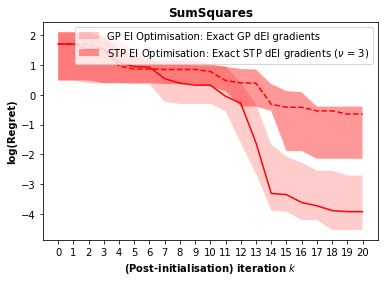

In [122]:
### Visualise!

title = func
plt.figure()

plt.plot(median_gp, color = 'Red', ls='-')
plt.plot(median_stp, color = 'Red', ls='--')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.2, label='GP EI Optimisation: Exact GP dEI gradients')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Red', alpha=0.4, label='STP EI Optimisation: Exact STP dEI gradients ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_gp, time_stp


(947.7223732471466, 1461.2158842086792)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncgp_gp_1 = acqFuncExact(gp_1.history)
acqFuncstp_stp_1 = acqFuncExact(stp_1.history)

e1 = np.mean(acqFuncstp_stp_1)
a1 = np.mean(acqFuncgp_gp_1)

e1, a1


(2.8621433422232405, 2.9740393016152176)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncgp_gp_2 = acqFuncExact(gp_2.history)
acqFuncstp_stp_2 = acqFuncExact(stp_2.history)

e2 = np.mean(acqFuncstp_stp_2)
a2 = np.mean(acqFuncgp_gp_2)

e2, a2


(2.845319006797472, 3.023113810674647)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncgp_gp_3 = acqFuncExact(gp_3.history)
acqFuncstp_stp_3 = acqFuncExact(stp_3.history)

e3 = np.mean(acqFuncstp_stp_3)
a3 = np.mean(acqFuncgp_gp_3)

e3, a3


(2.7594355450446417, 2.8089222432092993)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncgp_gp_4 = acqFuncExact(gp_4.history)
acqFuncstp_stp_4 = acqFuncExact(stp_4.history)

e4 = np.mean(acqFuncstp_stp_4)
a4 = np.mean(acqFuncgp_gp_4)

e4, a4


(2.8420246296995977, 2.9690590049552346)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncgp_gp_5 = acqFuncExact(gp_5.history)
acqFuncstp_stp_5 = acqFuncExact(stp_5.history)

e5 = np.mean(acqFuncstp_stp_5)
a5 = np.mean(acqFuncgp_gp_5)

e5, a5


(2.796132073213927, 2.977692700499412)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncgp_gp_6 = acqFuncExact(gp_6.history)
acqFuncstp_stp_6 = acqFuncExact(stp_6.history)

e6 = np.mean(acqFuncstp_stp_6)
a6 = np.mean(acqFuncgp_gp_6)

e6, a6


(2.966993364901202, 3.0951181970940915)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncgp_gp_7 = acqFuncExact(gp_7.history)
acqFuncstp_stp_7 = acqFuncExact(stp_7.history)

e7 = np.mean(acqFuncstp_stp_7)
a7 = np.mean(acqFuncgp_gp_7)

e7, a7


(2.981486562985613, 3.004745845239232)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncgp_gp_8 = acqFuncExact(gp_8.history)
acqFuncstp_stp_8 = acqFuncExact(stp_8.history)

e8 = np.mean(acqFuncstp_stp_8)
a8 = np.mean(acqFuncgp_gp_8)

e8, a8


(2.741553451339776, 2.8947097496195773)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncgp_gp_9 = acqFuncExact(gp_9.history)
acqFuncstp_stp_9 = acqFuncExact(stp_9.history)

e9 = np.mean(acqFuncstp_stp_9)
a9 = np.mean(acqFuncgp_gp_9)

e9, a9


(2.744956116908173, 2.847146960687158)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncgp_gp_10 = acqFuncExact(gp_10.history)
acqFuncstp_stp_10 = acqFuncExact(stp_10.history)

e10 = np.mean(acqFuncstp_stp_10)
a10 = np.mean(acqFuncgp_gp_10)

e10, a10


(2.908205486131391, 3.041778431605625)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncgp_gp_11 = acqFuncExact(gp_11.history)
acqFuncstp_stp_11 = acqFuncExact(stp_11.history)

e11 = np.mean(acqFuncstp_stp_11)
a11 = np.mean(acqFuncgp_gp_11)

e11, a11


(2.8222048169437994, 2.859336110840096)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncgp_gp_12 = acqFuncExact(gp_12.history)
acqFuncstp_stp_12 = acqFuncExact(stp_12.history)

e12 = np.mean(acqFuncstp_stp_12)
a12 = np.mean(acqFuncgp_gp_12)

e12, a12


(2.7676539413282453, 2.9269709083754747)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncgp_gp_13 = acqFuncExact(gp_13.history)
acqFuncstp_stp_13 = acqFuncExact(stp_13.history)

e13 = np.mean(acqFuncstp_stp_13)
a13 = np.mean(acqFuncgp_gp_13)

e13, a13


(2.872729598158215, 2.9111776714756505)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncgp_gp_14 = acqFuncExact(gp_14.history)
acqFuncstp_stp_14 = acqFuncExact(stp_14.history)

e14 = np.mean(acqFuncstp_stp_14)
a14 = np.mean(acqFuncgp_gp_14)

e14, a14


(2.852693376636711, 3.0015216621541843)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncgp_gp_15 = acqFuncExact(gp_15.history)
acqFuncstp_stp_15 = acqFuncExact(stp_15.history)

e15 = np.mean(acqFuncstp_stp_15)
a15 = np.mean(acqFuncgp_gp_15)

e15, a15


(2.7190191564488315, 2.860168621355661)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncgp_gp_16 = acqFuncExact(gp_16.history)
acqFuncstp_stp_16 = acqFuncExact(stp_16.history)

e16 = np.mean(acqFuncstp_stp_16)
a16 = np.mean(acqFuncgp_gp_16)

e16, a16


(2.798868866851616, 3.013338920776714)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncgp_gp_17 = acqFuncExact(gp_17.history)
acqFuncstp_stp_17 = acqFuncExact(stp_17.history)

e17 = np.mean(acqFuncstp_stp_17)
a17 = np.mean(acqFuncgp_gp_17)

e17, a17


(2.784201646333993, 2.8693015238920965)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncgp_gp_18 = acqFuncExact(gp_18.history)
acqFuncstp_stp_18 = acqFuncExact(stp_18.history)

e18 = np.mean(acqFuncstp_stp_18)
a18 = np.mean(acqFuncgp_gp_18)

e18, a18


(2.8607076084540024, 2.908718289326442)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncgp_gp_19 = acqFuncExact(gp_19.history)
acqFuncstp_stp_19 = acqFuncExact(stp_19.history)

e19 = np.mean(acqFuncstp_stp_19)
a19 = np.mean(acqFuncgp_gp_19)

e19, a19


(2.85589173023154, 2.890851475401242)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncgp_gp_20 = acqFuncExact(gp_20.history)
acqFuncstp_stp_20 = acqFuncExact(stp_20.history)

e20 = np.mean(acqFuncstp_stp_20)
a20 = np.mean(acqFuncgp_gp_20)

e20, a20


(2.8727148904288757, 2.9285166484101923)

In [120]:
### Summarize arrays: 

stp_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
gp_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(stp_stddev), np.mean(gp_stddev)


(2.8327467605530434, 2.9403114038603624)

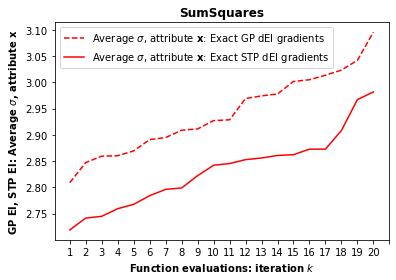

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(gp_stddev, color = 'Red', ls='--', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dEI gradients')
plt.plot(stp_stddev, color = 'Red', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Function evaluations: iteration $\it{k}$', weight = 'bold')
plt.ylabel('GP EI, STP EI: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualize!
